In [6]:
import torch
from yolo.data import CollateWithAnchors, CocoDataset, get_val_transforms
from yolo.visualize import render_bounding_boxes, plot
import itertools
from PIL import Image
from torchvision import tv_tensors
from torchvision.ops import box_convert
from torchvision.transforms.v2.functional import convert_bounding_box_format


from yolo.anchors import (
    make_spatial_anchors,
    make_scale_map,
    make_anchor_map,
    make_spatial_anchor_mask,
    encode_boxes,
    DecodeBoxes
)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
IMAGE_SIZE = 608
ANCHORS = [
    (10,13),
    (16,30),
    (33,23),
    (30,61),
    (62,45),
    (59,119),
    (116,90),
    (156,198),
    (373,326)
]
SCALES = [8, 16, 32]

val_dataset = CocoDataset(
    dataset_root = "/media/bryan/ssd01/fiftyone/coco-2017",
    split = "validation",
    transform = get_val_transforms(resize_size=IMAGE_SIZE)
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    pin_memory=True,
    drop_last=False,
    num_workers=0,
    collate_fn=CollateWithAnchors(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE, num_classes = val_dataset.num_classes)
)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


In [10]:
batch = next(iter(val_dataloader))

# Visualize the ground truth bounding boxes

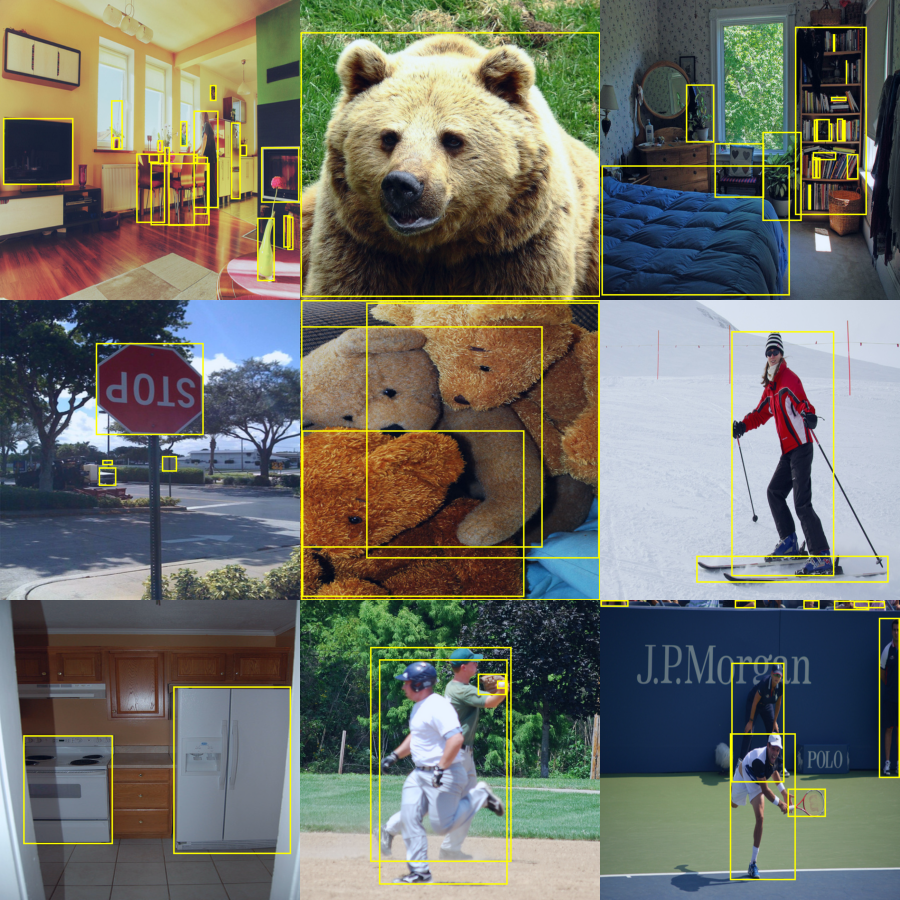

In [11]:
def flatten_batch(batch):
    keys = [k for k in batch.keys() if k != "image"]
    images = batch["image"]
    flat = []
    for i in range(len(images)):
        flat.append((images[i], {key: batch[key][i] for key in keys}))
    return flat

batch_flat = flatten_batch(batch)[:9]
batch_flat_reshape = [list(x) for x in itertools.batched(batch_flat, 3)]
vis = plot(batch_flat_reshape)
Image.fromarray(vis)

# Decode the TX_TY_TW_TH "Yolo style" encoded ground truth bounding boxes, and visualize.
## The image should exactly match the original gt bounding box vis

In [18]:
box_decoder = DecodeBoxes(ANCHORS, SCALES, IMAGE_SIZE, IMAGE_SIZE)
coord_bxbybwbh = box_decoder(batch["coordinates_label"])

In [19]:
num_boxes = sum([b.shape[0] for b in batch["boxes"]])
num_boxes

81

In [22]:
binary_mask = batch["gt_boxes_label"].bool()

In [23]:
non_zero_bxbybwbh = [coord_bxbybwbh[i][binary_mask[i].squeeze()] for i in range(coord_bxbybwbh.shape[0])]

In [24]:
sum([b.shape[0] for b in non_zero_bxbybwbh])

81

In [25]:
non_zero_boxes = [tv_tensors.BoundingBoxes(
    box,
    format="CXCYWH",
    canvas_size=(IMAGE_SIZE, IMAGE_SIZE)) for box in non_zero_bxbybwbh]
non_zero_boxes = [convert_bounding_box_format(x, new_format= tv_tensors.BoundingBoxFormat.XYXY) for x in non_zero_boxes]

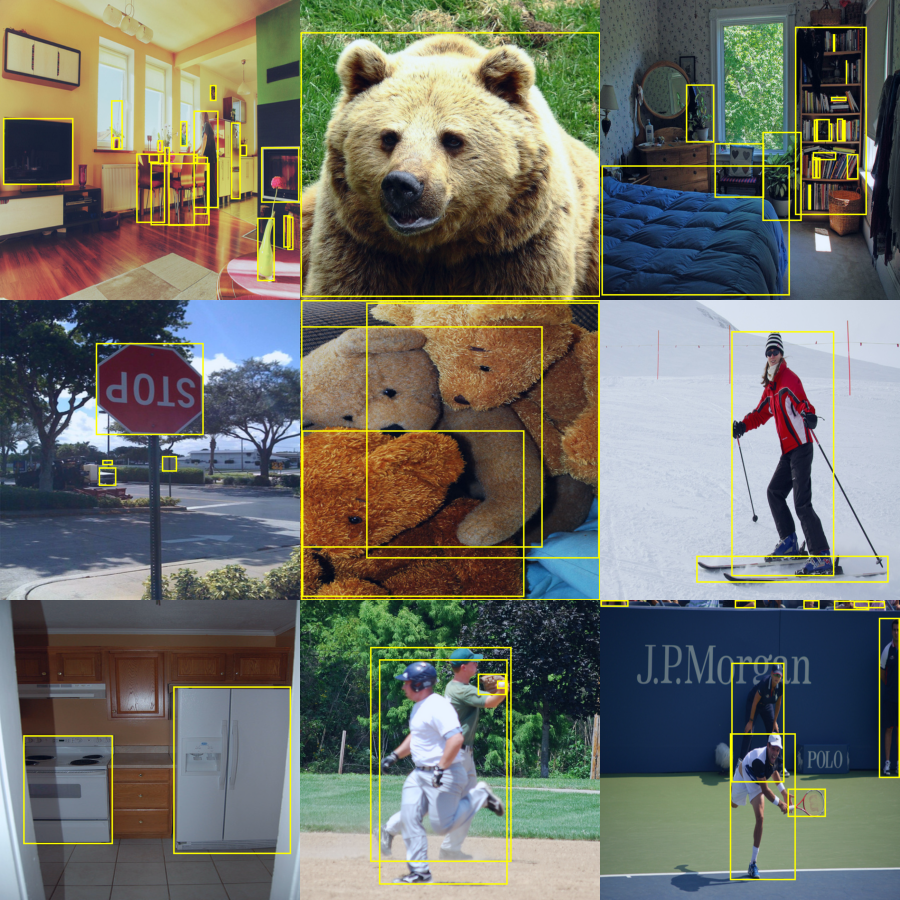

In [26]:
vis_tuples = [(image, {"boxes": boxes}) for image,boxes in zip(batch["image"], non_zero_boxes)][:9]
vis_tuples = [list(x) for x in itertools.batched(vis_tuples, 3)]
vis = plot(vis_tuples)
Image.fromarray(vis)

# Visualize the best anchor matching each ground truth bounding box

In [27]:
spatial_anchors = val_dataloader.collate_fn.spatial_anchors
anchor_boxes = [spatial_anchors[binary_mask[i].squeeze()] for i in range(binary_mask.shape[0])]
anchor_boxes = [tv_tensors.BoundingBoxes(
    box,
    format="XYXY",
    canvas_size=(IMAGE_SIZE, IMAGE_SIZE)) for box in anchor_boxes]

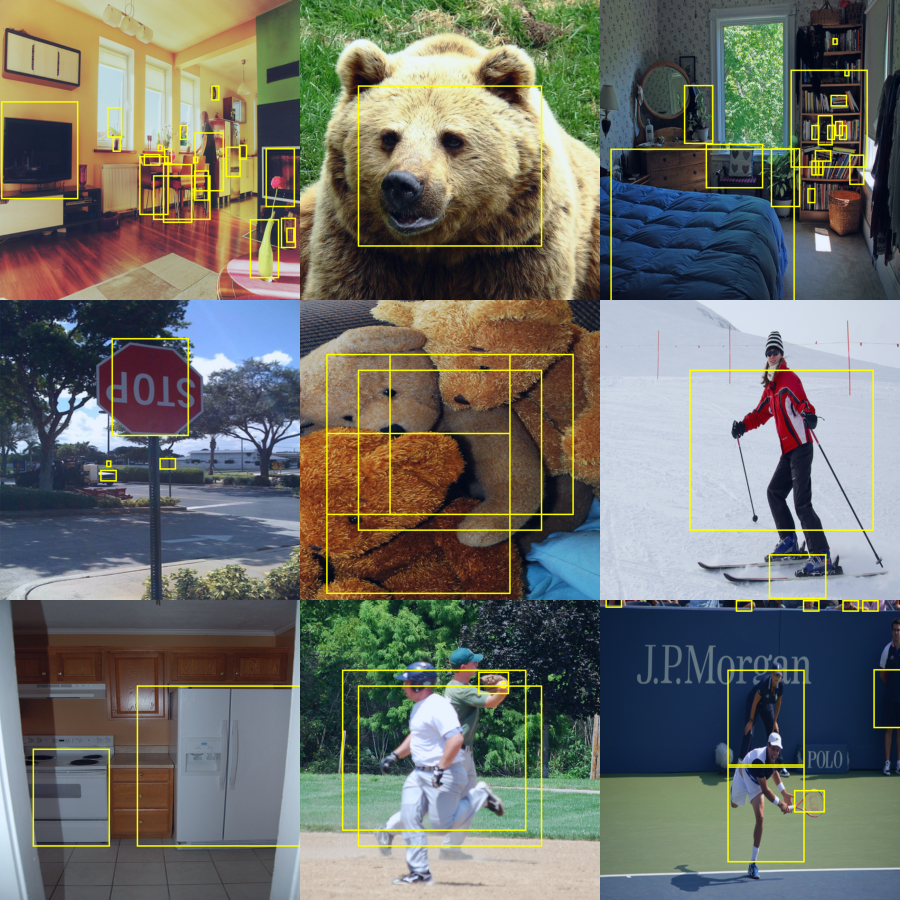

In [28]:
vis_tuples = [(image, {"boxes": boxes}) for image,boxes in zip(batch["image"], anchor_boxes)][:9]
vis_tuples = [list(x) for x in itertools.batched(vis_tuples, 3)]
vis = plot(vis_tuples)
Image.fromarray(vis)

# Evaluation metrics

In [91]:
import torchmetrics
from torchmetrics.detection import MeanAveragePrecision

In [78]:
targets = [{"boxes": boxes, "labels": labels, "iscrowd":iscrowd} for boxes,labels,iscrowd in zip(batch["boxes"], batch["class_idx"], batch["iscrowd"])]

In [99]:
preds = []
for anchor_box, target in zip(anchor_boxes, targets):
    preds.append({
        "boxes": anchor_box,
        "scores": 0.9 + torch.rand(len(anchor_box)) * 0.1,
        "labels": target["labels"],
    })

In [140]:
metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox", class_metrics=True)
# metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox", iou_thresholds = [0.1,], class_metrics=True)

In [141]:
metric.update(preds, targets)

In [142]:
from pprint import pprint

In [143]:
metric_out = metric.compute()
pprint(metric_out)

{'classes': tensor([ 0,  2,  7, 11, 21, 24, 26, 30, 32, 35, 38, 56, 58, 59, 60, 62, 68, 69,
        72, 73, 74, 75, 77], dtype=torch.int32),
 'map': tensor(0.0505),
 'map_50': tensor(0.1266),
 'map_75': tensor(0.),
 'map_large': tensor(0.1280),
 'map_medium': tensor(0.0098),
 'map_per_class': tensor([0.0236, 0.0000, 0.0000, 0.1010, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000,
        0.0757, 0.0092, 0.0000, 0.0172, 0.0337]),
 'map_small': tensor(0.0104),
 'mar_1': tensor(0.0470),
 'mar_10': tensor(0.0627),
 'mar_100': tensor(0.0627),
 'mar_100_per_class': tensor([0.0560, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000,
        0.1500, 0.0200, 0.0000, 0.0500, 0.0667]),
 'mar_large': tensor(0.1314),
 'mar_medium': tensor(0.0250),
 'mar_small': tensor(0.0164)}
